#### Imports - reward track wrapper

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math as meth 
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.monitor import Monitor

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
                                                                                    
import os
from stable_baselines3.common.logger import configure

class RewardTrackerCallback(BaseCallback):
    def __init__(self, verbose=0, check_freq=1000, window_size=100):
        super(RewardTrackerCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.window_size = window_size
        self.rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward from Monitor
            x, y = ts2xy(load_results(self.model.logger.dir), 'timesteps')
            if len(y) >= self.window_size:
                mean_reward = np.mean(y[-self.window_size:])
                self.rewards.append(mean_reward)
                self.timesteps.append(x[-1])
        return True

c:\Users\bunny\anaconda3\envs\gym\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Baseline PPO

Logging to ./logs_baseline/


c:\Users\bunny\anaconda3\envs\gym\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -500     |
| time/              |          |
|    fps             | 935      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 500        |
|    ep_rew_mean          | -500       |
| time/                   |            |
|    fps                  | 786        |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00842853 |
|    clip_fraction        | 0.0542     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | -0.0113    |
|    learning_rate        | 0.0003     |
|   

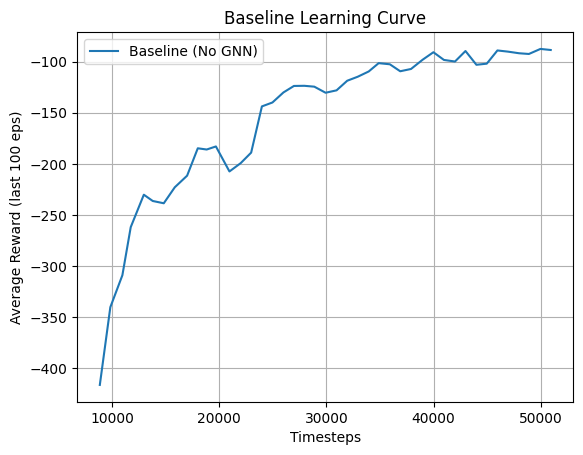

In [2]:

log_dir = "./logs_baseline/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("Acrobot-v1")
# Ensure that the Monitor writes to log_dir/monitor.csv
env = Monitor(env, log_dir + "monitor.csv")
env = DummyVecEnv([lambda: env])
env = VecMonitor(env)

# Create the model
model = PPO("MlpPolicy", env, verbose=0)

# Configure the logger to use the same directory
# This ensures load_results() and logger.dir match
new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)

baseline_callback = RewardTrackerCallback(check_freq=1000, window_size=20)
model.learn(total_timesteps=50000, callback=baseline_callback)

baseline_rewards = baseline_callback.rewards
baseline_timesteps = baseline_callback.timesteps

# %%
# Plot the baseline learning curve
plt.plot(baseline_timesteps, baseline_rewards, label="Baseline (No GNN)")
plt.xlabel("Timesteps")
plt.ylabel("Average Reward (last 100 eps)")
plt.title("Baseline Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

#### Random data collection

In [ ]:
# def collect_transitions(env_id="Acrobot-v1", num_steps=10000):
#     env = gym.make(env_id)
#     transitions = []
#     obs, _ = env.reset()
#     for _ in range(num_steps):
#         # Random action
#         action = env.action_space.sample()
#         next_obs, reward, terminated, truncated, info = env.step(action)
#         transitions.append((obs, action, reward, next_obs))
#         obs = next_obs
#         if terminated or truncated:
#             obs, _ = env.reset()
#     env.close()
#     return transitions

# transitions = collect_transitions(num_steps=100000)
# print("Collected transitions:", len(transitions))

#### Collecting data using trained PPO

In [4]:
def collect_transitions_with_values(model, env_id="Acrobot-v1", num_steps=10000):
    """
    Runs the trained PPO model for 'num_steps' in the environment
    and stores: (obs, action, reward, next_obs, value).
    """
    env = gym.make(env_id)
    transitions = []
    obs, _ = env.reset()
    for _ in range(num_steps):
        # Use the PPO model to get an action and the predicted value
        # 'model.predict' returns (action, state), but we also need value
        action, _ = model.predict(obs, deterministic=True)
        
        # Convert obs to correct shape for model’s value function
        obs_tensor = torch.tensor(obs, dtype=torch.float).unsqueeze(0)
        # Use the PPO’s policy/critic to get value estimate
        # stable-baselines3 doesn't expose a direct "critic forward" easily,
        # but we can do a workaround:
        device = model.device
        obs_tensor= obs_tensor.to(device)
        value = model.policy.predict_values(obs_tensor).item()
        next_obs, reward, done, truncated, info = env.step(action)
        transitions.append((obs, action, reward, next_obs, value))
        obs = next_obs
        if done or truncated:
            obs, _ = env.reset()
    env.close()
    return transitions

transitions_with_values = collect_transitions_with_values(model, "Acrobot-v1", 20000)
print("Collected transitions with value predictions:", len(transitions_with_values))


Collected transitions with value predictions: 20000


#### Building graph

In [5]:
def create_bins(low, high, bins):
    return np.linspace(low, high, bins + 1)

def discretize_state_acrobot(obs, bins_per_dim=10):
    """
    Acrobot observation: [cos(th1), sin(th1), cos(th2), sin(th2), th1_dot, th2_dot].
    We'll clamp the angular velocities to a reasonable range, then digitize each dimension.
    """
    # Ranges can be adjusted based on the environment’s dynamics or your preferences
    cos1_bins   = create_bins(-1.0, 1.0, bins_per_dim)
    sin1_bins   = create_bins(-1.0, 1.0, bins_per_dim)
    cos2_bins   = create_bins(-1.0, 1.0, bins_per_dim)
    sin2_bins   = create_bins(-1.0, 1.0, bins_per_dim)
    # Angular velocities: approximate max ranges or clamp them
    # e.g. [-4*pi, 4*pi] ~ [-12.56, 12.56] for th1_dot
    w1_bins     = create_bins(-12.56, 12.56, bins_per_dim)
    # e.g. [-9*pi, 9*pi] ~ [-28.27, 28.27] for th2_dot
    w2_bins     = create_bins(-28.27, 28.27, bins_per_dim)

    def clamp_and_bin(value, bin_edges):
        # clamp to avoid out-of-range digitize issues
        v_clamped = max(bin_edges[0], min(value, bin_edges[-1]))
        return np.digitize(v_clamped, bin_edges) - 1

    c1 = clamp_and_bin(obs[0], cos1_bins)
    s1 = clamp_and_bin(obs[1], sin1_bins)
    c2 = clamp_and_bin(obs[2], cos2_bins)
    s2 = clamp_and_bin(obs[3], sin2_bins)
    w1 = clamp_and_bin(obs[4], w1_bins)
    w2 = clamp_and_bin(obs[5], w2_bins)

    # Build the node_id from these 6 discrete indices
    b = bins_per_dim
    node_id = c1 + s1*b + c2*b**2 + s2*b**3 + w1*b**4 + w2*b**5
    return node_id, (c1, s1, c2, s2, w1, w2)


In [6]:
import numpy as np
import torch
from torch_geometric.data import Data

def build_graph_with_values_acrobot(transitions, bins_per_dim=10):
    """
    Build a graph from transitions of the form (s, a, r, s_next, val),
    where 'val' is the approximate value for state s.
    
    Returns:
      - graph_data: a torch_geometric.data.Data object with:
          - x: node feature matrix (num_nodes, 6)
          - edge_index: adjacency (2, num_edges)
          - edge_attr: edge features (num_edges, 2) for [action, reward]
      - node_id_map: dict from discretized node_id -> contiguous index in x
      - node_value_dict: dict from discretized node_id -> average value
    """
    node_features_dict = {}   # node_id -> np.array([c1, s1, c2, s2, w1, w2]) / (bins_per_dim-1)
    edges = []                # list of [src_id, dst_id]
    edge_attrs = []           # list of [action, reward]
    node_value_accumulator = {}  # node_id -> list of values

    for (s, a, r, s_next, val) in transitions:
        # Discretize current and next states
        src_id, (c1, s1, c2, s2, w1, w2) = discretize_state_acrobot(s, bins_per_dim)
        dst_id, (c1_, s1_, c2_, s2_, w1_, w2_) = discretize_state_acrobot(s_next, bins_per_dim)

        # Store node features if not present
        if src_id not in node_features_dict:
            node_features_dict[src_id] = np.array([c1, s1, c2, s2, w1, w2], dtype=np.float32) / (bins_per_dim - 1)
        if dst_id not in node_features_dict:
            node_features_dict[dst_id] = np.array([c1_, s1_, c2_, s2_, w1_, w2_], dtype=np.float32) / (bins_per_dim - 1)

        # Accumulate value
        if src_id not in node_value_accumulator:
            node_value_accumulator[src_id] = []
        node_value_accumulator[src_id].append(val)

        # Build edges
        # Make sure action, reward are cast to float
        a_float = float(a) if not isinstance(a, (float, np.floating)) else a
        r_float = float(r) if not isinstance(r, (float, np.floating)) else r
        edges.append([src_id, dst_id])
        edge_attrs.append([a_float, r_float])

    # Create torch_geometric Data
    unique_nodes = sorted(node_features_dict.keys())
    node_id_map = {nid: i for i, nid in enumerate(unique_nodes)}
    
    # Node features
    x = torch.tensor([node_features_dict[nid] for nid in unique_nodes], dtype=torch.float)
    # Edge index
    edge_index = torch.tensor([[node_id_map[e[0]] for e in edges],
                               [node_id_map[e[1]] for e in edges]], dtype=torch.long)
    # Edge features
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

    # Build the Data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # Compute average value per node
    node_value_dict = {}
    for nid in unique_nodes:
        vals = node_value_accumulator.get(nid, [])
        if len(vals) > 0:
            node_value_dict[nid] = float(np.mean(vals))
        else:
            node_value_dict[nid] = 0.0

    return graph_data, node_id_map, node_value_dict

import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph_data, node_id_map):
    """Visualize a PyTorch Geometric graph using NetworkX and matplotlib."""
    G = nx.DiGraph()  # Use DiGraph if edges are directed

    for i in range(graph_data.num_nodes):
        G.add_node(i)

    edge_list = graph_data.edge_index.t().tolist()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=50, node_color="skyblue", font_size=5,
            arrowsize=10, arrowstyle='-|>', connectionstyle='arc3,rad=0.1')
    plt.title("Graph Visualization")
    plt.show()

graph_data_val, node_id_map_val, node_value_dict_val = build_graph_with_values_acrobot(
    transitions_with_values, 
    bins_per_dim=10
)

print("Number of nodes:", graph_data_val.num_nodes)
print("Number of edges:", graph_data_val.num_edges)


Number of nodes: 3875
Number of edges: 20000


C:\Users\bunny\AppData\Local\Temp\ipykernel_12020\1564376898.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  x = torch.tensor([node_features_dict[nid] for nid in unique_nodes], dtype=torch.float)


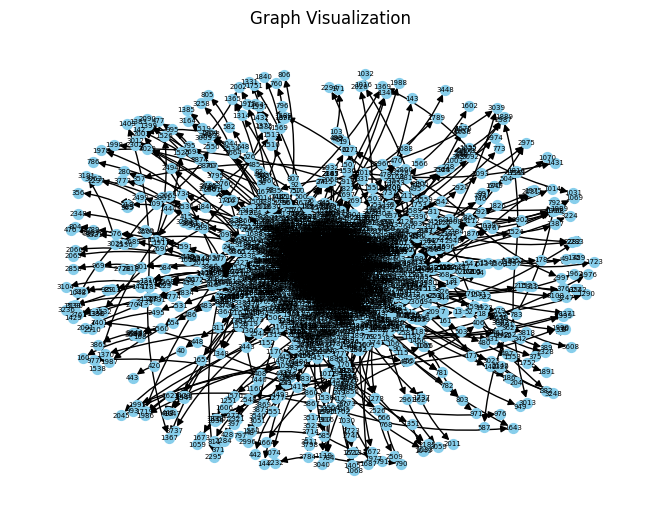

In [7]:
visualize_graph(graph_data_val, node_id_map_val)

#### Value-Based GNN Training

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import numpy as np


class GCNValueNetwork(nn.Module):
    def __init__(self, in_channels=6, hidden_channels=32, out_channels=16):
        """
        For Acrobot, we have 6 node features:
        [c1, s1, c2, s2, w1, w2] after discretization and normalization
        """
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.value_head = nn.Linear(out_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # x has shape (num_nodes, 6) for Acrobot
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        embeddings = x  # shape: (num_nodes, out_channels)
        values = self.value_head(embeddings).squeeze(-1)  # (num_nodes,)
        return embeddings, values


In [9]:
targets = []
unique_nodes = sorted(node_id_map_val.keys())
for nid in unique_nodes:
    targets.append(node_value_dict_val.get(nid, 0.0))  # default to 0.0 if not found
target_values = torch.tensor(targets, dtype=torch.float)


In [10]:
gnn_model = GCNValueNetwork(in_channels=6, hidden_channels=32, out_channels=16)
optimizer = optim.Adam(gnn_model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    optimizer.zero_grad()
    embeddings, values = gnn_model(graph_data_val)  # forward pass
    loss = nn.MSELoss()(values, target_values)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 2/10, Loss: 444.3723
Epoch 4/10, Loss: 442.6921
Epoch 6/10, Loss: 441.0249
Epoch 8/10, Loss: 439.3676
Epoch 10/10, Loss: 437.7165


#### Use Trained GNN Embeddings in a New PPO Run

In [11]:
with torch.no_grad():
    final_embeddings, predicted_values = gnn_model(graph_data_val)

# Map node ID -> embedding array
node_embedding_dict = {}
for i, nid in enumerate(unique_nodes):
    node_embedding_dict[nid] = final_embeddings[i].cpu().numpy()


In [12]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class GNNFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, bins_per_dim=10, embedding_dim=16):
        """
        For Acrobot, observation_space.shape[0] = 6.
        We'll produce features of dimension (6 + embedding_dim).
        """
        super().__init__(observation_space, features_dim=6 + embedding_dim)
        self.bins_per_dim = bins_per_dim
        self.embedding_dim = embedding_dim

    def forward(self, obs):
        # obs shape: (batch_size, 6) for Acrobot
        obs_np = obs.detach().cpu().numpy()
        batch_embeddings = []
        
        for o in obs_np:
            # discretize_state_acrobot returns (node_id, (c1, s1, c2, s2, w1, w2))
            node_id, _ = discretize_state_acrobot(o, self.bins_per_dim)
            embed = node_embedding_dict.get(node_id, np.zeros(self.embedding_dim, dtype=np.float32))
            batch_embeddings.append(embed)
        
        batch_embeddings = torch.tensor(batch_embeddings, dtype=torch.float, device=obs.device)
        # Concatenate the raw obs (6D) with the GNN embedding (16D)
        return torch.cat([obs, batch_embeddings], dim=1)

#### New training loop 

In [13]:
log_dir_gnn = "./logs_gnn_value_based/"
os.makedirs(log_dir_gnn, exist_ok=True)

env_gnn = gym.make("Acrobot-v1")
env_gnn = Monitor(env_gnn, log_dir_gnn + "monitor.csv")
env_gnn = DummyVecEnv([lambda: env_gnn])
env_gnn = VecMonitor(env_gnn)

gnn_logger = configure(log_dir_gnn, ["stdout", "csv", "tensorboard"])

gnn_policy_kwargs = dict(
    features_extractor_class=GNNFeaturesExtractor,
    features_extractor_kwargs=dict(bins_per_dim=10, embedding_dim=16)
)

gnn_model_rl = PPO("MlpPolicy", env_gnn, policy_kwargs=gnn_policy_kwargs, verbose=0)
gnn_model_rl.set_logger(gnn_logger)

gnn_callback = RewardTrackerCallback(check_freq=1000, window_size=20)
gnn_model_rl.learn(total_timesteps=50000, callback=gnn_callback)

gnn_rewards = gnn_callback.rewards
gnn_timesteps = gnn_callback.timesteps


Logging to ./logs_gnn_value_based/


c:\Users\bunny\anaconda3\envs\gym\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -500     |
| time/              |          |
|    fps             | 780      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 464         |
|    ep_rew_mean          | -464        |
| time/                   |             |
|    fps                  | 580         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008190714 |
|    clip_fraction        | 0.0677      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0535     |
|    learning_rate        | 0.

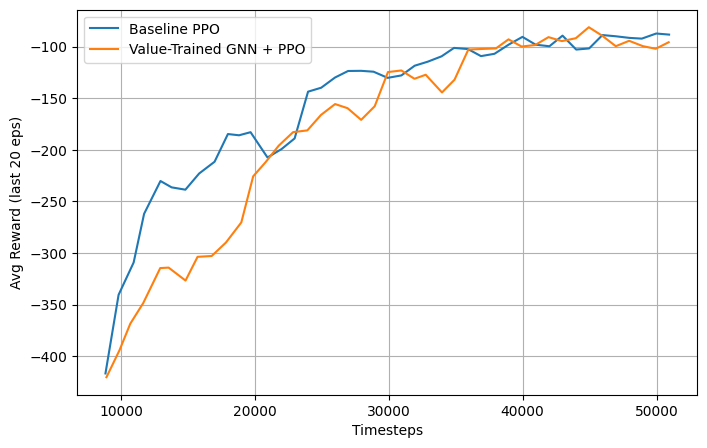

In [14]:
plt.figure(figsize=(8,5))
plt.plot(baseline_timesteps, baseline_rewards, label="Baseline PPO")
plt.plot(gnn_timesteps, gnn_rewards, label="Value-Trained GNN + PPO")
plt.xlabel("Timesteps")
plt.ylabel("Avg Reward (last 20 eps)")
plt.legend()
plt.grid(True)
plt.show()
